<a href="https://colab.research.google.com/github/MohamadHBaydoun/COMP9444/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/MohamadHBaydoun/COMP9444.git

Cloning into 'COMP9444'...
remote: Enumerating objects: 3469, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 3469 (delta 1), reused 0 (delta 0), pack-reused 3463 (from 1)
Receiving objects: 100% (3469/3469), 2.48 GiB | 39.85 MiB/s, done.
Resolving deltas: 100% (400/400), done.
Updating files: 100% (3835/3835), done.


In [1]:
# 0. Import packages
import os
import numpy as np
import pandas as pd
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# 1. Create model

import torch

class CustomFCN(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(CustomFCN, self).__init__()

        # Downsampling (Encoder)
        self.enc1a = self.conv_chain(in_channels, 3, 3, 8, 1, 1)
        self.enc1 = self.conv_chain(8, 3, 3, 8, 1, 1)
        self.pool1 = nn.MaxPool2d(2, stride=2)

        self.enc2a = self.conv_chain(8, 3, 3, 16, 1, 1)
        self.enc2 = self.conv_chain(16, 3, 3, 16, 1, 1)
        self.pool2 = nn.MaxPool2d(2, stride=2)

        self.enc3a = self.conv_chain(16, 3, 3, 32, 1, 1)
        self.enc3 = self.conv_chain(32, 3, 3, 32, 1, 1)
        self.pool3 = nn.MaxPool2d(2, stride=2)

       # Upsampling (Decoder)
        self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec1 = self.conv_chain(32, 3, 3, 16, 1, 1)

        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec2 = self.conv_chain(16, 3, 3, 8, 1, 1)

        self.up3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec3 = nn.Conv2d(in_channels=8, out_channels=out_channels, kernel_size=1, padding=0, stride=1)

    def conv_chain(self, Din, L, M, D, S, P):
      return nn.Sequential(
          nn.Conv2d(in_channels=Din, out_channels=D, kernel_size=(L, M), padding=P, stride=S),
          nn.BatchNorm2d(D),
          nn.ReLU(inplace=True)
      )

    def forward(self, x):
        # Encoder
        x1 = self.pool1(self.enc1a(x))
        x2 = self.pool2(self.enc2a(x1))
        x3 = self.pool3(self.enc3a(x2))
        #x1 = self.iterative_forward(x, self.pool1, self.enc1a, self.enc1)
        #x2 = self.iterative_forward(x1, self.pool2, self.enc2a, self.enc2)
        #x3 = self.iterative_forward(x2, self.pool3, self.enc3a, self.enc3)

        # Decoder
        y = self.up1(x3)
        y = self.dec1(y)
        y = y + x2

        y = self.up2(y)
        y = self.dec2(y)
        y = y + x1

        y = self.up3(y)
        y = self.dec3(y)

        return torch.sigmoid(y)
    def iterative_forward(self, x, poolFunc, encFuncA, encFunc):
        # Encoder
        xNew = encFuncA(x)
        for i in range(7):
          xNew = encFunc(xNew)
        return poolFunc(xNew)

# Create model instance
model = CustomFCN()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(model)



CustomFCN(
  (enc1a): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (enc1): Sequential(
    (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2a): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (enc2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (pool2): MaxPool2d(kernel_size=2, 

In [8]:
# 2. Prepare data
IMAGE_PATH = "./top_200_images/images"
LABEL_PATH = "./top_200_images/"

def load_image(path, isLabel=False):
    """Load an RGB image and convert to a tensor"""
    img = Image.open(path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((480, 640)),  # Resize images
        transforms.ToTensor(),  # Convert to tensor

    ])
    if isLabel:
      transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((480, 640)),  # Resize images
        transforms.ToTensor(),  # Convert to tensor
    ])
    return transform(img)  # Apply transform

class QuakeCityDataset(torch.utils.data.Dataset):
    def __init__(self, file_list):
        self.file_list = file_list

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        filename = self.file_list[idx]
        img = load_image(os.path.join(IMAGE_PATH, filename))
        # component = load_annotation("component", filename)
        crack = load_image(os.path.join(LABEL_PATH, "crack", filename), isLabel=True)
        # spall = load_annotation("spall", filename)
        # rebar = load_annotation("rebar", filename)
        # ds = load_annotation("ds", filename)
        # depth = load_annotation("depth", filename)
        label = crack
        return img, label

all_files = sorted(os.listdir(IMAGE_PATH))
split_idx = int(0.5*len(all_files))
train_files = all_files[split_idx:]
test_files = all_files[:split_idx]

train_dataset = QuakeCityDataset(train_files)
test_dataset = QuakeCityDataset(test_files)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

img_test_batch, label_test_batch = next(iter(train_loader))
print("Test image batch shape:", img_test_batch.shape)
print("Test label batch shape:", label_test_batch.shape)

Test image batch shape: torch.Size([64, 3, 480, 640])
Test label batch shape: torch.Size([64, 1, 480, 640])


In [10]:
# 2.5 Visualise data
def visualize_sample(image, label):
    """Display the image and its 6 label masks."""
    label_names = ["Component", "Crack", "Spall", "Rebar", "Damage State", "Depth"]
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))

    # Show the original image
    axes[0].imshow(image.permute(1, 2, 0))  # Convert (C, H, W) -> (H, W, C)
    axes[0].set_title("Original Image")
    axes[0].axis("off")
    # Show the label mask
    axes[1].imshow(label.squeeze(), cmap='gray')  # Visualize label
    axes[1].set_title(label_names[1])
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

img_batch, label_batch = next(iter(train_loader))
visualize_sample(img_batch[0], label_batch[0])

KeyboardInterrupt: 

In [6]:
# 3. Choose optimizer

criterion = nn.BCELoss()  # binary classification loss
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

Epoch   1, Batch   0: loss =  0.0403, output_mean =  0.0105, target_mean =  0.0069


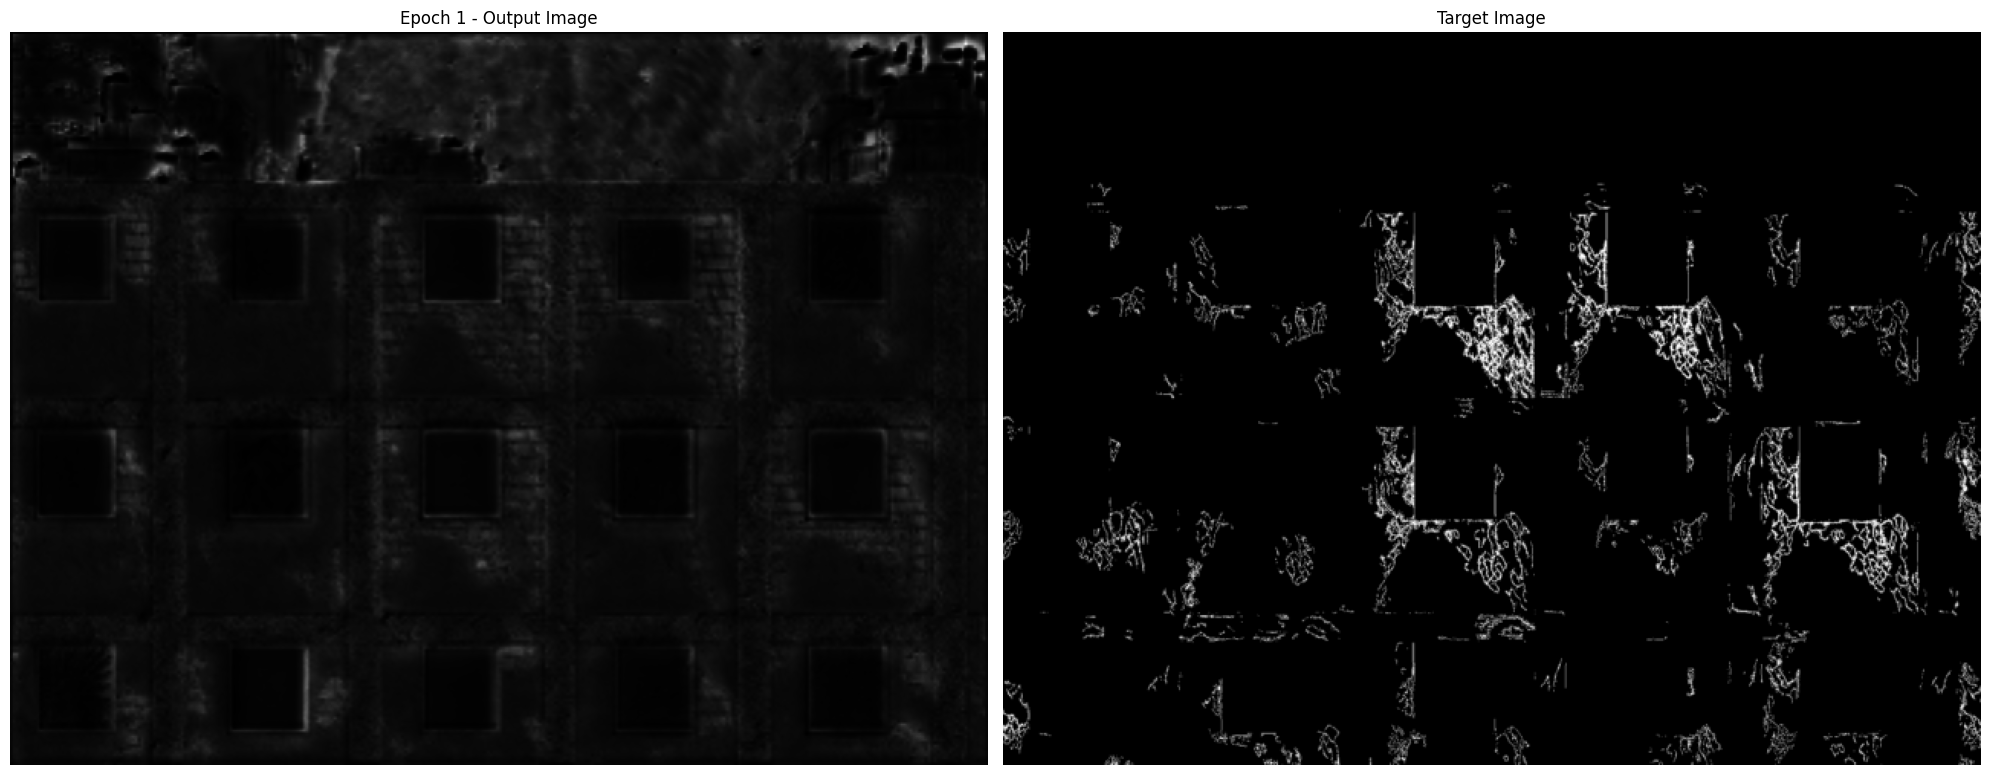

Epoch   1, Batch   1: loss =  0.0449, output_mean =  0.0106, target_mean =  0.0081


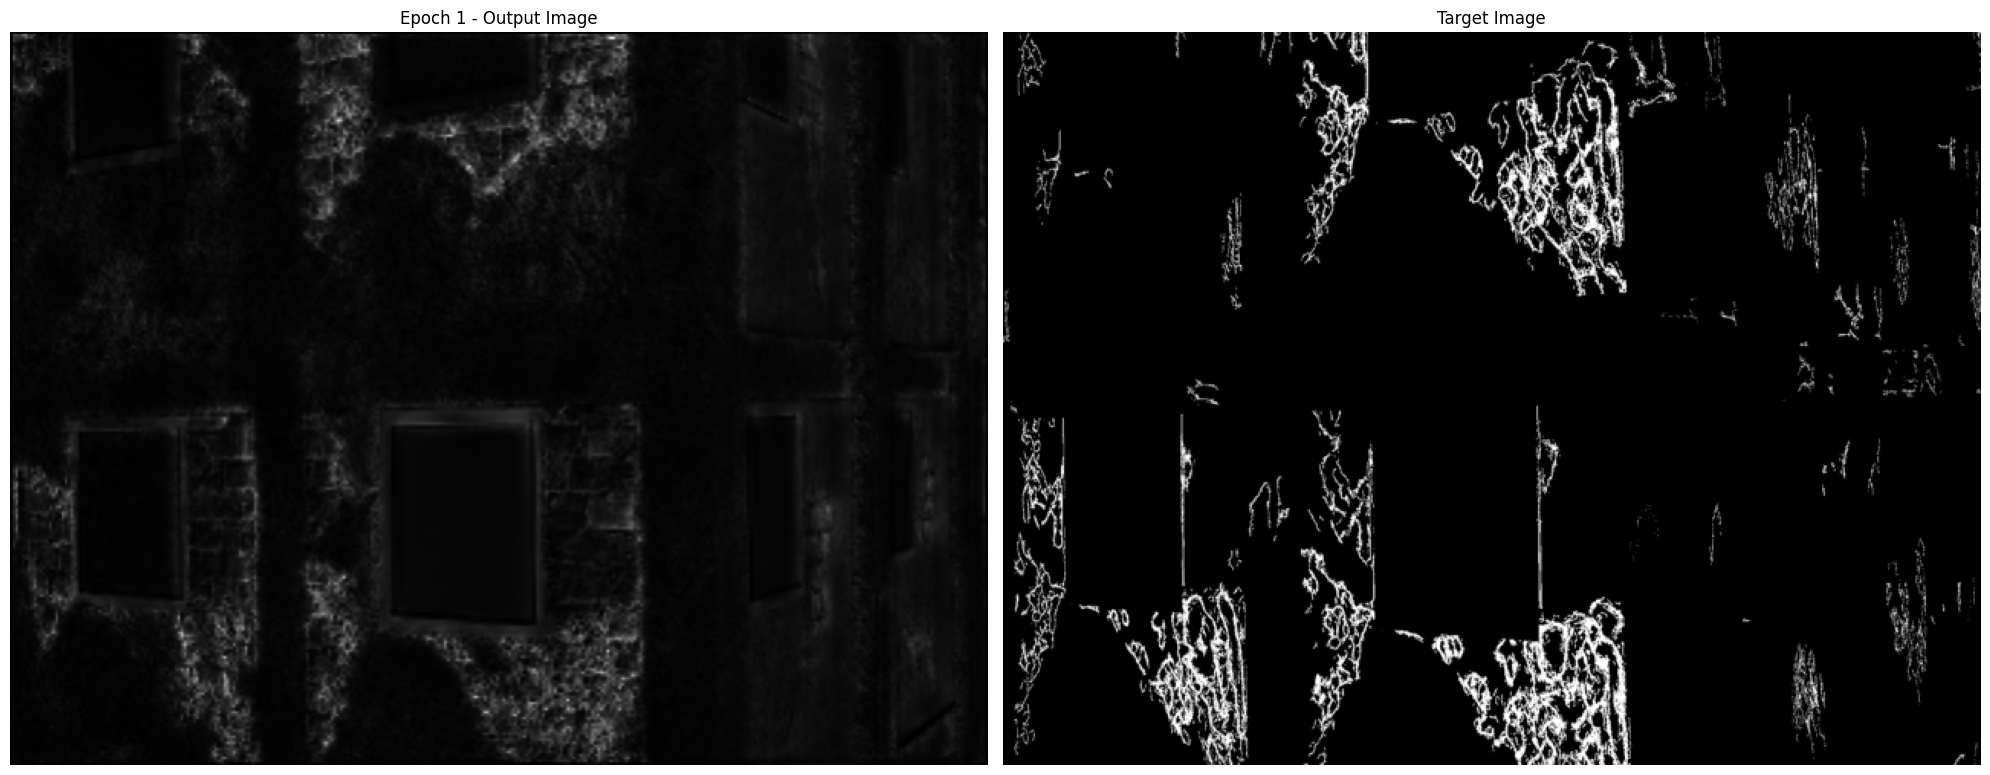

Epoch   1, Batch   2: loss =  0.0444, output_mean =  0.0104, target_mean =  0.0079


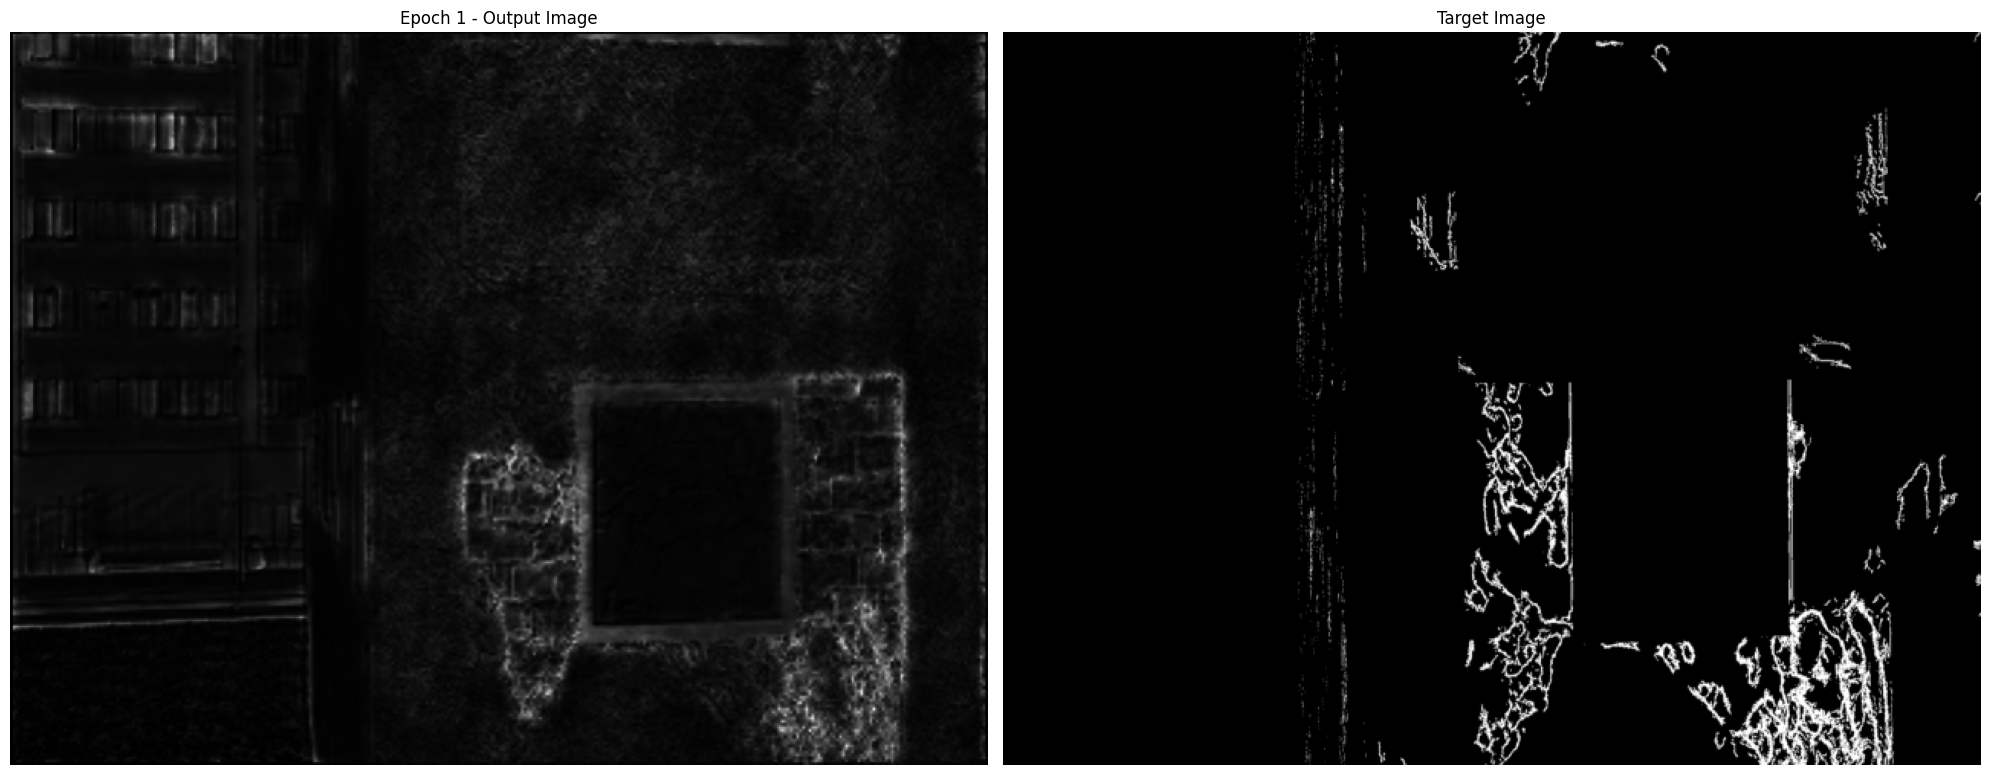

Epoch   1, Batch   3: loss =  0.0379, output_mean =  0.0116, target_mean =  0.0062


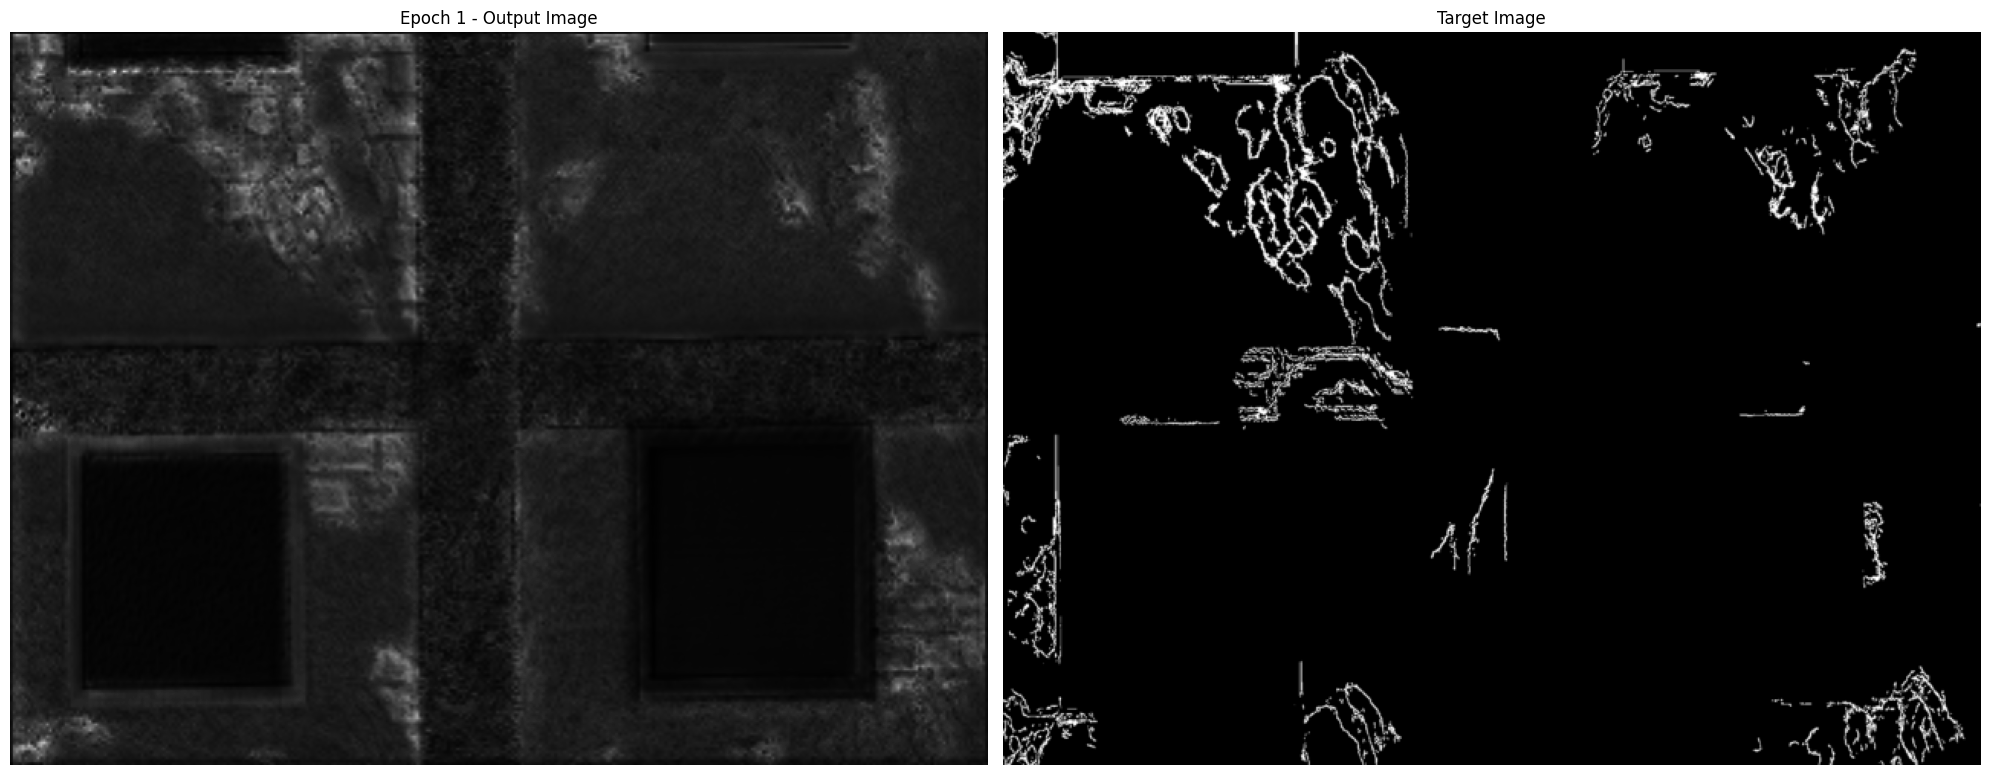

Epoch 1 Average Loss: 0.0419
Epoch   2, Batch   0: loss =  0.0434, output_mean =  0.0106, target_mean =  0.0077


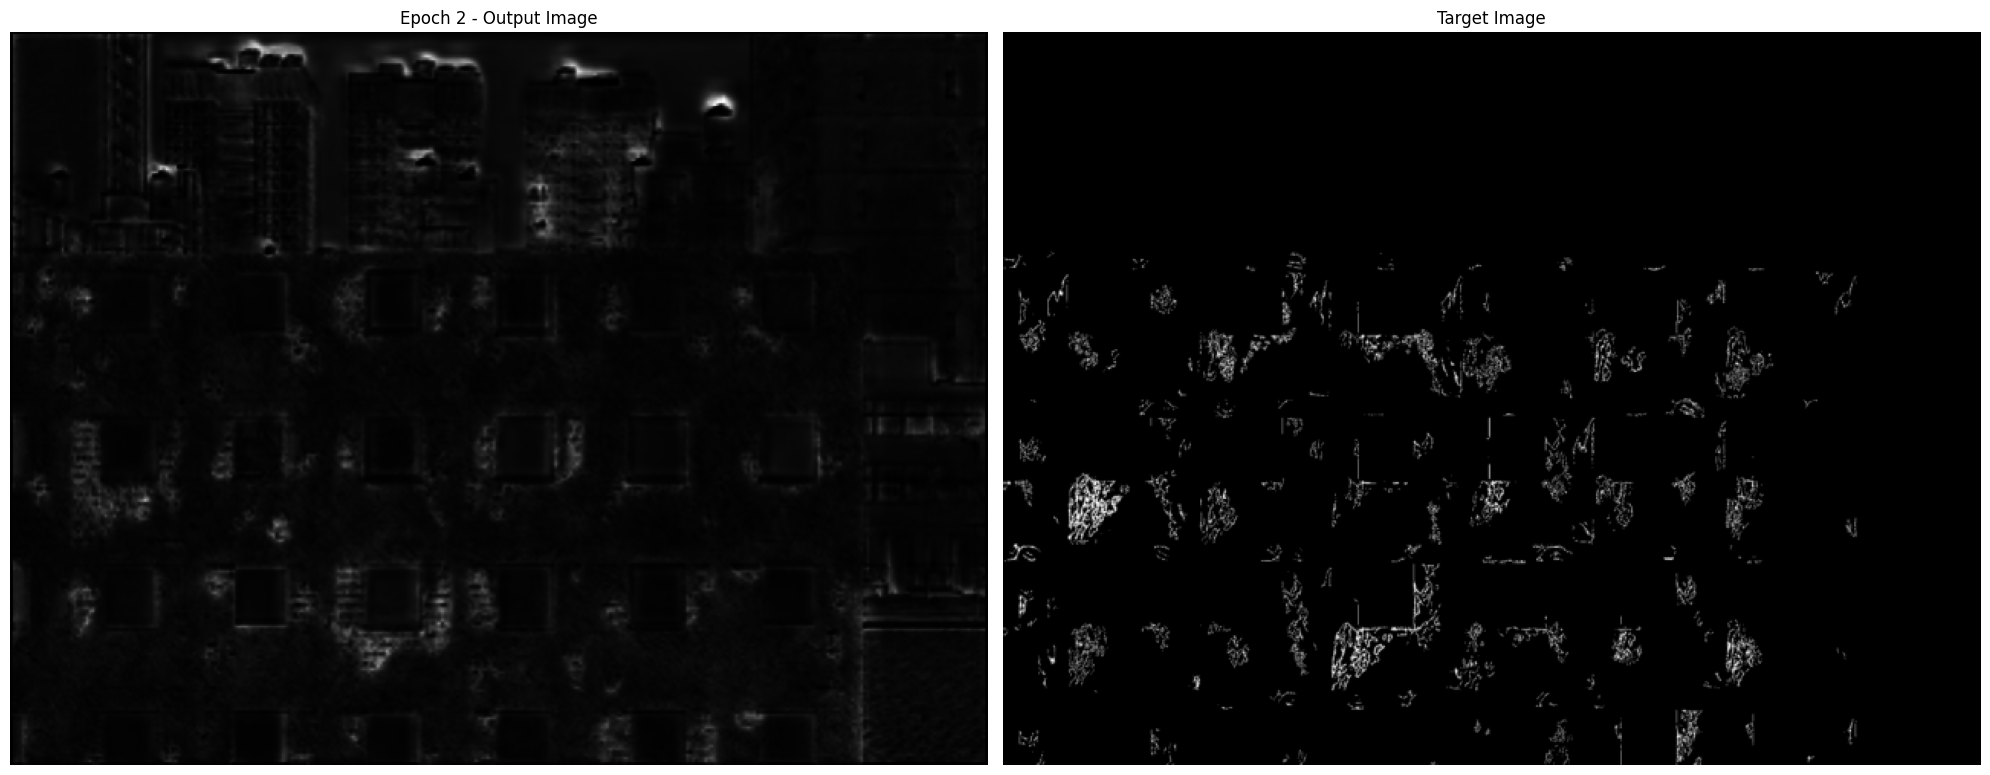

In [ ]:
import matplotlib.pyplot as plt

losses = []
epoch_losses = []
epochs = 500

for epoch in range(1, epochs):
    epoch_loss_total = 0
    num_batches = 0

    for batch_id, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)

        loss.backward()
        optimizer.step()

        # Save and print loss
        batch_loss = loss.item()
        losses.append(batch_loss)
        epoch_loss_total += batch_loss
        num_batches += 1

        print('Epoch %3d, Batch %3d: loss = %7.4f, output_mean = %7.4f, target_mean = %7.4f' %
              (epoch, batch_id, batch_loss, output.mean().item(), target.mean().item()))

        # Compare results
        output_image = output[-1].cpu().detach().numpy()
        target_image = target[-1].cpu().detach().numpy()

        fig, axes = plt.subplots(1, 2, figsize=(20, 10))
        axes[0].imshow(output_image.squeeze(), cmap='gray')
        axes[0].set_title(f"Epoch {epoch} - Output Image")
        axes[0].axis("off")

        axes[1].imshow(target_image.squeeze(), cmap='gray')
        axes[1].set_title("Target Image")
        axes[1].axis("off")

        plt.tight_layout()
        plt.show()

    # Compute and log average loss for this epoch
    avg_epoch_loss = epoch_loss_total / num_batches
    epoch_losses.append(avg_epoch_loss)
    print(f"Epoch {epoch} Average Loss: {avg_epoch_loss:.4f}")
    plt.figure(figsize=(10, 4))
    plt.plot(epoch_losses, label='Average Epoch Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Average Loss per Epoch')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
def iou_score(outputs, targets, threshold=0.5):
    outputs = (outputs > threshold).float()
    intersection = (outputs * targets).sum()
    union = outputs.sum() + targets.sum() - intersection
    iou = intersection / union
    return iou.item()

def dice_coefficient(outputs, targets, threshold=0.5):
    outputs = (outputs > threshold).float()
    intersection = (outputs * targets).sum()
    dice = (2 * intersection) / (outputs.sum() + targets.sum())
    return dice.item()

model.eval()
total_iou, total_dice = 0, 0

with torch.no_grad():
    for images, masks in test_loader:
        #images, masks = images.cuda(), masks.cuda()

        with torch.cuda.amp.autocast():
            outputs = model(images)

        total_iou += iou_score(outputs, masks)
        total_dice += dice_coefficient(outputs, masks)

# Average metrics for the epoch
avg_iou = total_iou / len(test_loader)
avg_dice = total_dice / len(test_loader)
print(f'Validation - IoU: {avg_iou:.4f}, Dice: {avg_dice:.4f}')